In [ ]:
# Nodes
import torch
import torch.nn as nn
import numpy as np
np.random.seed(0)
torch.manual_seed(0)

class Linear (nn.Module):
    def __init__(self, w, in_w, use_bias=True, activation=None):
        super(Linear, self).__init__()
        self.W = nn.Parameter(torch.zeros(w, in_w))
        self.b = nn.Parameter(torch.zeros(1, w)) if use_bias else None
        nn.init.xavier_uniform_(self.W)
        self.use_bias = use_bias
        if use_bias:
            nn.init.zeros_(self.b)

        if use_bias:
            nn.init.zeros_(self.b)
        self.act = activation
        if activation == 'relu':
            self.act = torch.relu
        elif activation == 'sigmoid':
            self.act = torch.sigmoid
        elif activation == 'tanh':
            self.act = torch.tanh
        elif activation == 'none':
            self.act = torch.nn.Identity()
        else:
            raise ValueError(f'Activation function {activation} not supported')
        
        #print(f'Linear layer, W.shape {self.W.shape}. Expected input shape [?, {in_w}], output shape [?, {w}]')

    def forward(self, x):
        out = torch.mm(x, self.W.t())
        if self.b is not None:
            out += self.b
        if self.act:
            out = self.act(out)
        return out

class FeedForward(nn.Module):
    def __init__(self, l1:int, l2:int, prob:float, act1:str, act2:str,  in_w:int):
        super(FeedForward, self).__init__()
        print(f'FeedForward: l1={l1}, l2={l2}, prob={prob}, act1={act1}, act2={act2}, in_w={in_w}')
        self.l_in = Linear(l1, in_w, False, act1)
        self.dropout = nn.Dropout(prob)
        self.l_out = Linear(l2, l1, True, act2)
    
    def forward(self, x):
        return self.l_out(self.dropout(self.l_in(x)))


class Attention(nn.Module):
    def __init__(self, w, in_w, use_bias=False, activation=None):
        super(Attention, self).__init__()
        print(f'Attention, w={w}, in_w={in_w}, use_bias={use_bias}, activation={activation}')
        self.Q = Linear(w, in_w, use_bias, activation)
        self.K = Linear(w, in_w, use_bias, activation)
        self.V = Linear(w, in_w, use_bias, activation)


    def forward(self, x):
        q = self.Q(x)
        k = self.K(x)
        v = self.V(x)
        qkt = torch.mm(q, k.t())
        qkt /= torch.sqrt(torch.tensor(k.size(1), dtype=torch.float32))
        qkt = torch.softmax(qkt, dim=1)
        return torch.mm(qkt, v)

class MultiHeadAttention(nn.Module):
    def __init__(self, n, w, in_w, use_bias=True, activation=None):
        super(MultiHeadAttention, self).__init__()
        print(f'MultiHeadAttention, n={n}, w={w}, in_w={in_w}, use_bias={use_bias}, activation={activation}')
        self.heads = [Attention(w,in_w, use_bias, activation) for _ in range(n)]
        self.out = Linear(w, w * n, use_bias, activation)

    def forward(self, x):
        head_outs = [head(x) for head in self.heads]
        head_out = torch.cat(head_outs, dim=1)
        x = self.out(head_out)
        return x

In [ ]:
# Larger MHA - MLP model
import random

torch.manual_seed(100)
random.seed(100)

class EmoModel(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

        self.MLP1 = FeedForward(192, 128, 0.5, 'relu', 'tanh', 300)
        self.MHA1 = MultiHeadAttention(1, 64, 128, False, 'relu')
        self.Lin1 = Linear(6, 64, False, 'sigmoid')
        self.Lin2 = Linear(1, 64, False, 'sigmoid')
        self.softmax = nn.Softmax(dim=0)

    def forward(self, x):
        x = self.MLP1(x)
        x = self.MHA1(x)
        x = self.Lin1(x)
        x = x.t()
        x = self.Lin2(x)
        x = self.softmax(x).t()
        return x

In [ ]:
# Iris data and model

import pandas as pd
df = pd.read_csv('static_data/iris_train.csv')
# convert last column of df to class
df['class'] = df['variety'].map({'Setosa': [0, 0, 1], 'Versicolor': [0, 1, 0], 'Virginica': [1, 0, 0]})
del df['variety']
iris_data = df.to_numpy()
np.random.seed(20)
np.random.shuffle(iris_data)

import torch.nn as nn
class IrisModel(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        #self.seq = nn.Sequential(
        #    nn.Linear(4, 16),
        #    nn.ReLU(),
        #    nn.Linear(16, 3),
        #)
        self.seq = FeedForward(16, 3, .25, 'relu', 'none', 4)

    def forward(self, x):
        return self.seq(x)

loss = torch.nn.CrossEntropyLoss()

In [ ]:
# Read emotion dataset.

import os
import pickle
import torch.nn.functional as F

def read_vectors(file):
    vectors = {}
    with open(file, 'r') as f:
        for line in f:
            try:
                word, *vector = line.split()
                vectors[word] = torch.tensor([float(x) for x in vector])
            except:
                print("Failed to read line", line)
                pass
    return vectors

vec_file = '/home/ishwark/word2vecdata/wiki.multi.en.vec'
pickle_file = '/home/ishwark/word2vecdata/word2idx.pkl'

if not os.path.exists(pickle_file):
    print("writing pickles")
    vecs = read_vectors(vec_file)
    with open(pickle_file, 'wb') as f:
        pickle.dump(vecs, f)

with open('/home/ishwark/word2vecdata/word2idx.pkl', 'rb') as f:
    vecs = pickle.load(f)


# read a text file with the following format
# word1 word2 word3 ... wordn, int

def read_sentences(file):
    data = []
    with open(file, 'r') as f:
        f.readline()
        for line in f:
            try:
                words, label = line.split(',')
                label = F.one_hot(torch.tensor(int(label)), num_classes=6).float()
                data.append((words.split(), label))
            except:
                print("Failed to read line", line)
    return data

def sentence_to_tensor(sentence, vectors, max_words=64):
    sentence = sentence[:max_words]
    vecs = [vectors[word] for word in sentence if word in vectors]
    vecs += [torch.zeros_like(vecs[0]) for _ in range(max_words - len(vecs))]
    return torch.stack(vecs)

sents = read_sentences('/home/ishwark/word2vecdata/emotion/split/train.csv')

In [ ]:
# Train Iris model

import numpy as np
import torch
torch.set_printoptions(precision=10, sci_mode=False, edgeitems=2000)
np.random.seed(20)
torch.manual_seed(10)

model = IrisModel()

optimizer = torch.optim.Adam(model.parameters(), lr=3e-3)
batch_losses = [0]
err_cts = list([0])
weight_norms = []
grad_norms = []
sample = 0
file = open('error.txt', 'w')
n, f = [None, None], [None, None]
loss2 = torch.nn.MSELoss()
optimizer.zero_grad()
batch_size = 32

while True:
    #random.shuffle(sents)
    #for sentence, label in sents:
    for row in iris_data:
        #x = sentence_to_tensor(sentence, vecs)
        x1 = torch.from_numpy(np.array(row[:-1], dtype=float))
        t = torch.tensor(row[-1])
        y = model(x1.view(1, -1).float())
        t = t.view(1, -1).float()

        l = loss(y, t)
        l.backward()

        err_cts[-1] += (torch.argmax(t) != torch.argmax(y)).item()
        batch_losses[-1] += l.item()
        if (sample + 1) % batch_size == 0:
            batch = sample // batch_size
            
            model.eval()
            y = model(x1.view(1, -1).float())
            t = t.view(1, -1).float()
            l = loss2(y, t)

            if batch % 100 == 0 and False:
                lout_w_norm = model.seq.l_out.W.norm(p=2).item()
                lin_w_norm = model.seq.l_in.W.norm(p=2).item()
                lout_wg_norm = model.seq.l_out.W.grad.norm(p=2).item()
                lin_wg_norm = model.seq.l_in.W.grad.norm(p=2).item()
                weight_norms.append((batch, lin_w_norm, lout_w_norm ))
                grad_norms.append((batch, lin_wg_norm, lout_wg_norm))
                print( batch, f"\nl_out W | G norm: {lout_w_norm:2.3f} | {lout_wg_norm:2.3f} ",
                              f"\nl_out W | G norm: {lin_w_norm:2.3f} | {lin_wg_norm:2.3f} ")

            print(sample, err_cts[-1], l.item(), y.tolist(), t.tolist(), file=file)
            optimizer.step()
            optimizer.zero_grad()
            model.train()
            batch_losses[-1] /= batch_size
            batch_losses.append(0)
            err_cts.append(0)
        sample += 1 
    if sample > batch_size * 2500:
        break
batch_losses = [(i, l) for i, l in enumerate(batch_losses)]
err_cts = [(i, l) for i, l in enumerate(err_cts)]
file.close()

In [ ]:
#  Plot Iris Python train
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
main_plot = batch_losses[:-1]

y1 = np.array([t[0] for t in main_plot])
x1 = np.array([t[1] for t in main_plot])

y2 = np.array([t[0] for t in weight_norms])
x2 = np.array([t[1] for t in weight_norms])

y3 = np.array([t[0] for t in grad_norms[1:-1]])
x3 = np.array([t[1] for t in grad_norms[1:-1]])

smoothed = pd.Series(x1).rolling(window=16).mean().to_numpy()[16:]

transparent_red = (1,0,0,.5)
plt.plot(y1, x1, label="err_ct", color='orange', alpha=.5)
plt.plot(y1[16:], smoothed, label="smoothed", color='orange')
#plt.plot(y2, x2, '-x', label="w_norm", color='blue', alpha=.5)
#plt.plot(y3, x3, label="g_norm", color='green', alpha=.5)

plot_title = "Train Loss/Validation Loss"
plt.title(plot_title)
plt.xlabel("Batch")
plt.ylabel("Loss")
#plt.yscale('log')

plt.legend()

In [ ]:
# Plot data from "losses.csv", from C++ training
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

df = pd.read_csv("train_losses.csv")
df = df[:]
y = np.array(df["batch"])
x1 =  np.array(df["loss"])
x2 = np.array(df["misses"])
smooth_loss = np.array(df['loss'].rolling(window=16).mean())
smooth_err = np.array(df['misses'].rolling(window=16).mean())

plot_loss = True
transparent_red = (1,0,0,.5)
if plot_loss:
    plt.plot(y, x1, label="train_loss", color='orange', alpha=.33)
    plt.plot(y, smooth_loss, label="train_loss_16", color='orange', alpha=1.)
else:
    plt.plot(y, x2, label="misses", color='cyan', alpha=0.15)
    plt.plot(y, smooth_err, label="smooth_misses", color='cyan', alpha=1.)

try:
    df = pd.read_csv("valdn_losses.csv")
    v_batches = np.array(df["batch"])
    v_losses =  np.array(df["loss"])
    v_misses = np.array(df["misses"])
    if plot_loss:
        plt.plot(v_batches, v_losses, 'x', label="valdn_loss", color='teal', )
    else:
        plt.plot(v_batches, v_misses, label="v_misses", color='teal')
except:
    ...
plot_title = "Train Loss/Validation Loss"
plt.title(plot_title)
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.yscale('log')
plt.legend()

In [ ]:
import pandas as pd

import pandas as pd

splits = {'train': 'split/train-00000-of-00001.parquet', 'validation': 'split/validation-00000-of-00001.parquet', 'test': 'split/test-00000-of-00001.parquet'}
for k, v in splits.items():
    df = pd.read_parquet("hf://datasets/dair-ai/emotion/" + v)
    print(f"{k}: {df.shape}")
    df.to_csv(f"static_data/emotion_{k}.csv", index=False)
    print(df.head())


In [ ]:
# read magnitudes CSV, which has 19 columns, first row is header, each row is bunch of magnitudes over time:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('magnitudes.csv')
del df['Unnamed: 19']

for col in [c for c  in df.columns[1:] if '_W{' in c]:
    # plot against "df['idx']"
    plt.plot(df[col],  label=col)
plt.legend()

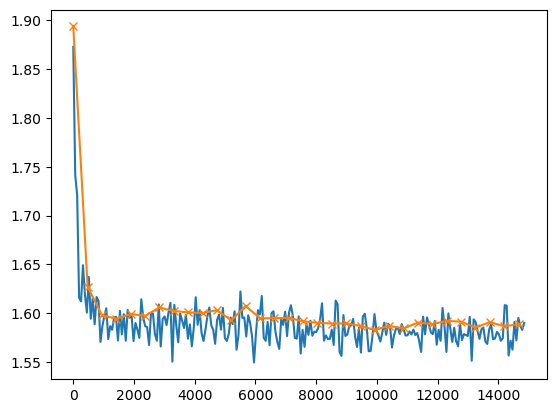

In [5]:
# read a file with numbers plot them

import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv("loss.txt", header=None)
t_batches = df[0].to_numpy()
losses = df[1].to_numpy()
skip = 0
plt.plot(t_batches[skip:], losses[skip:])

df_valdn = pd.read_csv("valdn_loss.txt", header=None)

v_batches = df_valdn[0].to_numpy()
v_losses = df_valdn[1].to_numpy()
plt.plot(v_batches[skip:], v_losses[skip:], '-x')